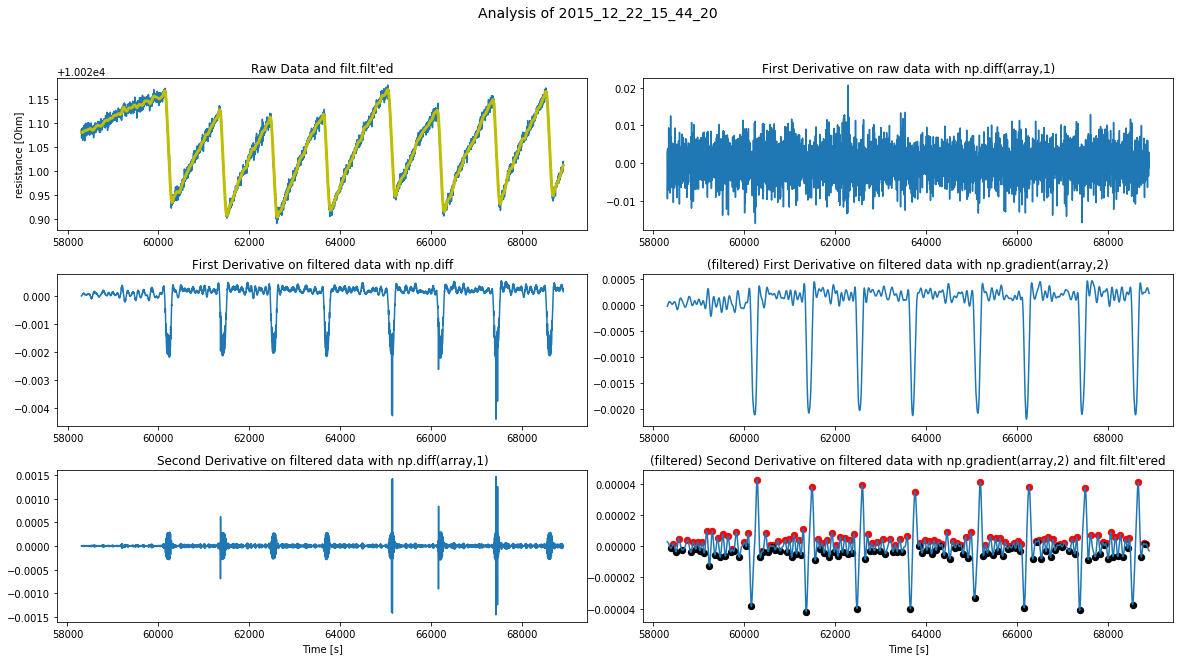

In [107]:
import numpy as np
import matplotlib.pyplot as pyplt
import matplotlib

dirname = "."
dir_img = "./img/"
# filtration of noise inspired by https://stackoverflow.com/questions/28536191/how-to-filter-smooth-with-scipy-numpy
# See also the documentation on filtfilt here
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.filtfilt.html
from scipy.signal import butter, filtfilt, argrelextrema

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    sm_y = filtfilt(b, a, data)
    return sm_y

# Parameters used for the filtration of noisy data
cutoff = 1500
fs = 50000

fig = pyplt.figure(figsize=(10.0,3.0))
fig.tight_layout()

Core_data = np.loadtxt(fname='./sample_data/2015_12_22_15_44_20_strip.dat', skiprows=1)
data = Core_data[-5000:-10][:]

#Core_data = np.loadtxt(fname='2015_12_21_16_30_06_strip.dat', skiprows=1)
#data = Core_data[-13000:][:]

time = data[:,0]
resistance = data[:,1]

#Smoothing of resistance data using filtfilt.
y_smooth = butter_lowpass_filtfilt(resistance, cutoff, fs=60000)

# By finite differences, the first order derivative of the smoothed y axes for each mean value of x over your array is given by:
dy=np.diff(y_smooth,1) # note that the first derivative is calculated over y_smooth, *not* resistance
dx=np.diff(time,1)

dy_raw = np.diff(resistance,1)
dy_smooth_gradient=np.gradient(y_smooth,4)
dx_gradient=np.gradient(time,4)

#dx=np.gradient(time,1)
yfirst=dy/dx
yfirst_raw=dy_raw/dx
yfirst_gradient = dy_smooth_gradient/dx_gradient
yfirst_gradient = butter_lowpass_filtfilt(yfirst_gradient, cutoff=1500, fs=60000)

# [...] the corresponding values of x are 
xfirst=0.5*(time[:-1]+time[1:])

# Should one need to smooth the first derivative as well
yfirst_smooth = butter_lowpass_filtfilt(yfirst, cutoff=1500, fs=10000)

# For the second order, do the same process again
dyfirst=np.diff(yfirst,1)
dxfirst=np.diff(xfirst,1)
ysecond=dyfirst/dxfirst

dyfirst_gradient = np.gradient(yfirst_gradient,3)
dxfirst_gradient = np.gradient(time,3)
ysecond_gradient = dyfirst_gradient/dxfirst_gradient
ysecond_gradient = butter_lowpass_filtfilt(ysecond_gradient, cutoff=1500, fs=60000)

maxima = argrelextrema(ysecond_gradient, np.greater)
minima = argrelextrema(ysecond_gradient, np.less)

# the corresponding values of x are: 
xsecond=0.5*(xfirst[:-1]+xfirst[1:])

# create a grid for the plots and arrangements of plots
f = pyplt.figure(figsize=(20,10))
gs = matplotlib.gridspec.GridSpec(6, 6, hspace=0.8, wspace=0.4)
f.suptitle("Analysis of 2015_12_22_15_44_20", fontsize=14)

ax1 = f.add_subplot(gs[:2,:3])
ax2 = f.add_subplot(gs[2:4,:3])
ax3 = f.add_subplot(gs[4:6,:3])
ax4 = f.add_subplot(gs[:2,3:6])
ax5 = f.add_subplot(gs[2:4,3:6])
ax6 = f.add_subplot(gs[4:6,3:6])

#Populating the plots
#ax1: original data plus smoothing
ax1.plot(time,resistance)
ax1.set_ylabel("resistance [Ohm]")
ax1.set_title("Raw Data and filt.filt'ed")
ax1.plot(time,y_smooth, color='y', linewidth=3.0)


ax2.plot(xfirst,yfirst)
#ax3.plot(time,yfirst)
#ax2.set_ylabel("dy/dx")
#ax2.set_xlabel("Time [s]")
ax2.set_title("First Derivative on filtered data with np.diff")

ax3.plot(xsecond,ysecond)
#ax4.plot(time,ysecond)
#ax3.set_ylabel("d2y/d2x")
ax3.set_xlabel("Time [s]")
ax3.set_title("Second Derivative on filtered data with np.diff(array,1)")

ax4.set_title("First Derivative on raw data with np.diff(array,1)")
ax4.plot(xfirst,yfirst_raw)

ax5.plot(time, yfirst_gradient)
ax5.set_title("(filtered) First Derivative on filtered data with np.gradient(array,2)")

ax6.set_xlabel("Time [s]")
ax6.plot(time, ysecond_gradient)
ax6.scatter(time[maxima],ysecond_gradient[maxima], marker='o', linestyle='None', s=40, c='red')
ax6.scatter(time[minima],ysecond_gradient[minima], marker='o', linestyle='None', s=40, c='black')

ax6.set_title("(filtered) Second Derivative on filtered data with np.gradient(array,2) and filt.filt'ered")

# pyplt.savefig(dir_img+"/"+"derivate_filters"+".png")
pyplt.show()


## Selection of "correct" maxima and minima in the second derivative
At this point we have a series of maxima and minima, but only the **larger** maxima and minima, in module, are the ones poiting at the end and the beginning of the heating runs, respectively. The smaller maxima and minima in between are artefact of the filtering that was applied to the data. What you really need then is to make a selection of those maxima and minima that will point you to the heating runs.
Let's first try with a selection based on the value of the maxima and the minima.

<function matplotlib.pyplot.plot>

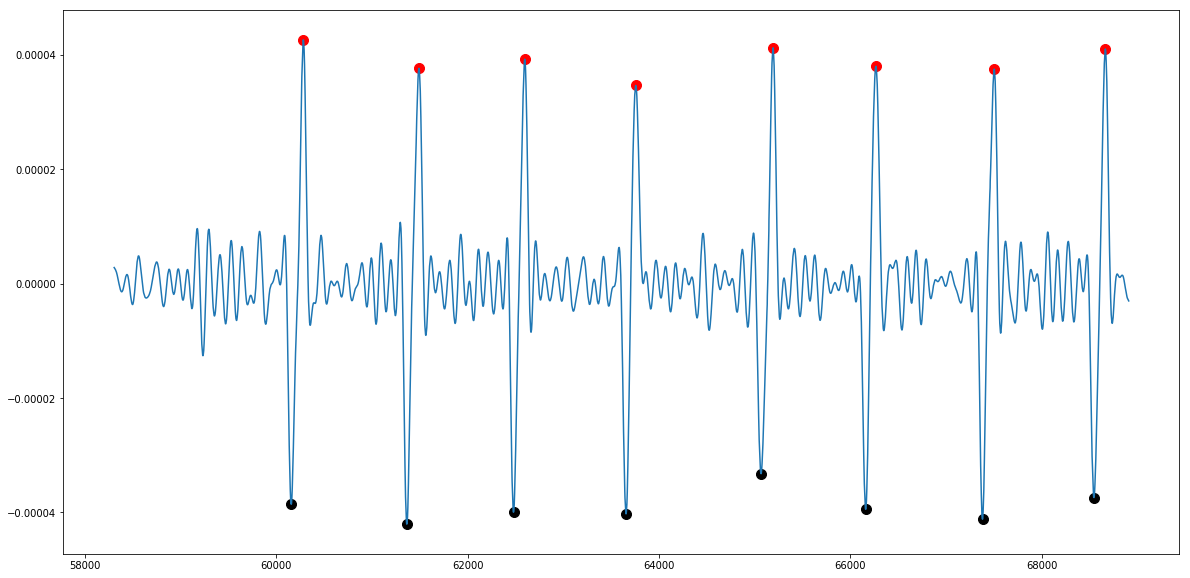

In [3]:
ymins = ysecond_gradient[minima] # subselection of ysecond_gradient
tmins = time[minima] # subselection of time
ymaxs = ysecond_gradient[maxima]
tmaxs = time[maxima]

# The threshold value might depend on the noise and this procedure may need generalization.
min_index = ysecond_gradient[minima] < -2.0e-5
max_index = ysecond_gradient[maxima] > 2.0e-5

t_beginnings = tmins[min_index]
t_ends = tmaxs[max_index]

%matplotlib inline
pyplt.figure(figsize=(20,10))
pyplt.plot(time, ysecond_gradient)
pyplt.scatter(tmaxs[max_index],ymaxs[max_index], marker='o', s=100, c='red')
pyplt.scatter(tmins[min_index],ymins[min_index], marker='o', s=100, c='black')
# pyplt.savefig(dir_img+"/"+"selection_of_maxima"+".png")
pyplt.plot

## Identification of the beginning and the end of each run on the resistance plots
The _minima_ of the second derivative, after appropriate polishing for the artefacts introduced by differentation of noisy data, are useful to identify the _beginning_ of a haeting run, while the _maxima_ correspond to the _end_ of the heating run. However maxima and minima of the second derivative are much smaller arrays than the original `time` and `resistance` arrays, so first one needs to locate the index values of these minima and maxima on the original arrays. 

<function matplotlib.pyplot.plot>

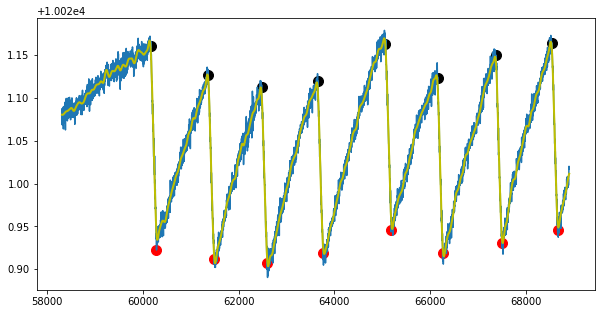

In [4]:
time_mins = np.isin(time,t_beginnings) # finds the position of the real minima back in the orginal 'time' array
time_maxs = np.isin(time,t_ends)

%matplotlib inline
pyplt.figure(figsize=(10,5))
pyplt.plot(time,resistance)
#pyplt.set_ylabel("resistance [Ohm]")
#pyplt.set_title("Raw Data and filt.filt'ed")
pyplt.plot(time,y_smooth, color='y', linewidth=2.0)
pyplt.scatter(time[time_mins],resistance[time_mins], marker ='o', s=100, c='black')
pyplt.scatter(time[time_maxs],resistance[time_maxs], marker='o', s=100, c='red')
#pyplt.savefig(dir_img+"/"+"localizing_starts_ends"+".png")
pyplt.plot

## Linear regressions and extrapolations to the mid-run
As common in graphite calorimetry for radiation dosimetry, the _relative resistance change_ during the heating run is determined via a _forward extrapolation_ of the pre-heating trend, and a _backwards extrapolation_ of the post-heating trend, both at _mid-run_. These trends are determined via linear fitting of the corresponding trend data over a time span of 120". The linear fitting data, the extrapolations, and further computations will be saved in a proper array (or list?)

In [5]:
#ends = ends[1:]
# ends[1] = 500
assert len(t_beginnings) == len(t_ends), 'Number of minima and maxima is not equal. Cannot define heating runs.'
heating_times = t_ends - t_beginnings
pos = heating_times > 0 
assert pos.all(), 'Heating time returned negative in one heating cycle. Cannot calculate deltaR/R'
#for n in heating_times:
#    if heating_times[n] < 120:
#        print(heating_times[n]) 
#heating_times.all(TRUE)
#for n in heating_times:
#    assert n>0, 'Heating time negative in cicle:'
    
#ass.all()

In [6]:
import math

def find_nearest(array,value):
    '''Returns the index of the element of an array that is neares to a value'''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        #return array[idx-1]
        return idx-1
    else:
        #return array[idx]
        return idx

In [7]:
def generate_fit_regions(array, fit_margin, span=120, direction='backwards'):
    '''Returns a new two-dimensional array with indices of where the linear fits will take place.
    
    Parameters
    ----------
    array : ndarray
        The array with all the times, intended in seconds
    fit_ends : ndarray
        The array containing all the indices where the fit ends (or starts)
    span : int
        The interval over which to carry out the linear regressions. Defaults to 2' (120").
    direction : string
        Specifies whether moving forward or backwards (default) on the array
    
    Returns
    -------
    out: ndarray
        Array of dtype=int with the indices defining the regions for (later) linear regressions
    '''
    assert len(fit_margin) > 0, 'Cannot define any fitting region'
    fit_array = np.empty([2,len(fit_margin)], dtype=int)
    if direction == 'forward':
        for i in range(0, len(fit_margin)):
            fit_array[0,i] = np.searchsorted(array,fit_margin[i])
            fit_array[1,i] = find_nearest(array, array[fit_array[0,i]]+span)
    elif direction == 'backwards':
        for i in range(0,len(fit_margin)):
            fit_array[1,i] = np.searchsorted(array,fit_margin[i])
            fit_array[0,i] = find_nearest(array, array[fit_array[1,i]]-span)
    return fit_array

<function matplotlib.pyplot.plot>

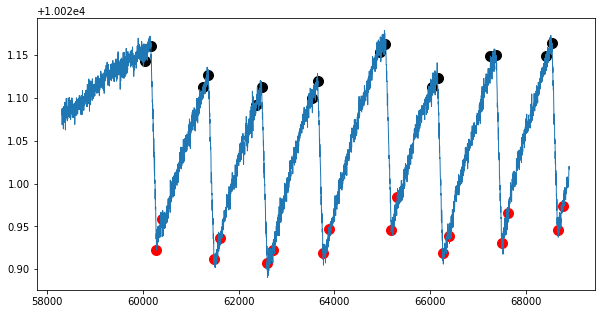

In [8]:
fit_pre_heat = generate_fit_regions(time, t_beginnings, 120, 'backwards')
fit_post_heat = generate_fit_regions(time, t_ends, 120, 'forward')
# time[temp[0,]]

%matplotlib inline
pyplt.figure(figsize=(10,5))
pyplt.plot(time,resistance, linewidth=1.0)

#pyplt.plot(time,y_smooth, color='y', linewidth=3.0)
pyplt.scatter(time[time_mins],resistance[time_mins], marker ='o', s=100, c='black')
pyplt.scatter(time[fit_pre_heat[0,]],resistance[fit_pre_heat[0,]], marker ='o', s=100, c='black')
pyplt.scatter(time[time_maxs],resistance[time_maxs], marker='o', s=100, c='red')
pyplt.scatter(time[fit_post_heat[1,]],resistance[fit_post_heat[1,]], marker ='o', s=100, c='red')
#pyplt.savefig(dir_img+"/"+"localize_fitting_regions"+".png")
pyplt.plot

### Organization of output data in columns 

| Heating starts (s) | Heating ends (s) | Midpoint (s) | delta_T (s) | pre-slope | pre-intercept | Resistance-pre | post-slope | post-intercept | Resistance-post | delta_R | R_mid_average | delta_R_over_R | slopes_control |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---|
| 1600 | 1720 | 1660 | 120 | 1.04e-4 | 5e-5| 10004.5 | bla | bla | 10004.22 | 0.255 | 10004.3 | 2.5 e-5 | 0.30367314 | 
| 1900 | 2020 | 1960 | 120 | 1.05e-4 | 5.2e-5| 10004.2 | bla | bla | 10002.12 |0.245 | 10004.24 | 2.45 e-5 | 0.2772314 |

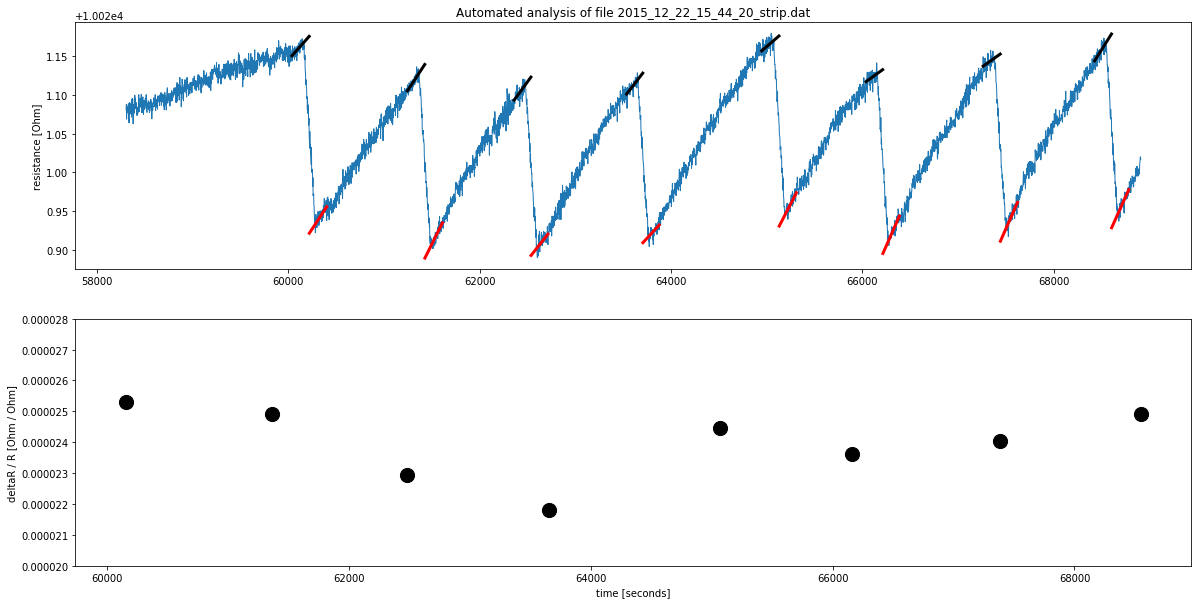

In [81]:
from scipy import stats

# Preparation of data for the linear fits and for their extrapolations.
x1 = fit_pre_heat[0,] # indices of the beginning of the linear fit, pre-heating drifts
x2 = np.searchsorted(time,time[time_mins]) # indices of the end of the linear fit, pre-heating drifts
x3 = np.searchsorted(time,time[time_maxs]) # indices of the beginning of the linear fit, post-heating drifts
x4 = fit_post_heat[1,] # indices of the end of the linear fit, post-heating drifts
delta_T = time[fit_post_heat[0,]] - time[fit_pre_heat[1,]] # heating run durations (seconds)
half_runs = time[fit_pre_heat[1,]] + 0.5*delta_T # midpoints of heating run (seconds) 
xmid = np.empty([len(half_runs)], dtype=int) # indices of the midpoints
for i in range(0,len(xmid)):
    xmid[i] = find_nearest(time, half_runs[i])

assert ((len(x1) == len(x2)) & (x1 < x2).all()), '''Number of linear fit extremes in pre-heating drifts 
is not equal or left limit(s) > right limit(s)'''
assert ((len(x3) == len(x4)) & (x3 < x4).all()), '''Number of linear fit extremes in post-heating drifts 
is not equal or left limit(s) > right limit(s)'''

fit_results_pre = np.empty([5,len(x1)], dtype=float)
fit_results_post= np.empty([5,len(x1)], dtype=float)
for i in range(0, len(x1)):
    fit_results_pre[:,i]  = stats.linregress(time[x1[i]:x2[i]],resistance[x1[i]:x2[i]])
    fit_results_post[:,i] = stats.linregress(time[x3[i]:x4[i]],resistance[x3[i]:x4[i]])

R_mid_pre  = fit_results_pre[0,:]*time[xmid]+fit_results_pre[1,:]
R_mid_post = fit_results_post[0,:]*time[xmid]+fit_results_post[1,:]

#Organize results in a numpy array    
results = np.vstack((t_beginnings, t_ends, half_runs, delta_T, fit_results_pre[0,:],fit_results_pre[1,:],R_mid_pre))    
results = np.vstack((results, fit_results_post[0,:], fit_results_post[1,:], R_mid_post))

delta_R = abs(results[6,]-results[9,])
R_mid_average = 0.5*abs(results[6,]+results[9,])
delta_R_over_R = delta_R / R_mid_average
slopes_control = abs(abs(results[4,]-abs(results[7,]))) / (0.5*(abs(results[4,]+abs(results[7,])))) # relative difference of the pre-drift and post-drift slopes. An indicator of thermal equilirbium

results = np.vstack((results, delta_R, R_mid_average, delta_R_over_R, slopes_control))

#slope, intercept, r_value, p_value, std_err = np.empty([len(half_runs)], dtype=float)
#slope, intercept, r_value, p_value, std_err = stats.linregress(time[x1[0]:x2[0]],resistance[x1[0]:x2[0]])
#fit_results[:,0] = stats.linregress(time[x1[0]:x2[0]],resistance[x1[0]:x2[0]])
#line1 = slope*time[x1[0]:xmid[0]]+intercept # ok thus far, though you now need to extrapolate.

# create a list of numpy arrays of variable lenghts, each corresponding to a best fit line
line_pre = [] # empty
line_post = [] 
for i in range(0, len(x2)):
    line_pre.append(fit_results_pre[0,i]*time[x1[i]:xmid[i]] + fit_results_pre[1,i])
    line_post.append(fit_results_post[0,i]*time[xmid[i]:x4[i]] + fit_results_post[1,i])


%matplotlib inline
results_fig = pyplt.figure(figsize=(20,10))
results_grid = matplotlib.gridspec.GridSpec(2, 1, hspace=0.2, wspace=0.1)
ax1 = results_fig.add_subplot(results_grid[0,0])
ax2 = results_fig.add_subplot(results_grid[1,0])

ax1.plot(time,resistance, linewidth=1.0)
for i in range(0, len(x2)):
    ax1.plot(time[x1[i]:xmid[i]], line_pre[i], color='black', linewidth=3.0)
    ax1.plot(time[xmid[i]:x4[i]], line_post[i], color='red', linewidth=3.0)
#ax1.plot(time,resistance)
ax1.set_ylabel("resistance [Ohm]")
ax1.set_title("Automated analysis of file 2015_12_22_15_44_20_strip.dat")

ax2.set_ylim(2e-5,2.8e-5)
ax2.scatter(time[time_mins],delta_R_over_R, s=200, c='black')
ax2.set_ylabel("deltaR / R [Ohm / Ohm]")
ax2.set_xlabel("time [seconds]")

pyplt.savefig(dir_img+"/"+"final_results"+".png")
pyplt.show()

### Defining grid plots with individual fitting regions
This segment creates a grid of plots, where each plot shows individual heating runs with its pre-heating and psot-heating drifts, plus a few text annotations on each plot. This is similar to that I saw from Claus Andersen using dplyr. 

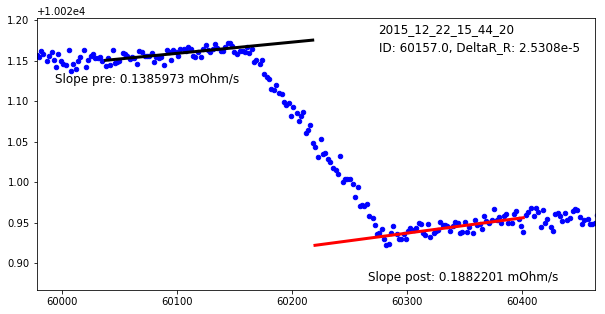

In [92]:
%matplotlib inline
XEDGE = 60
results_fig = pyplt.figure(figsize=(10,5))
results_grid = matplotlib.gridspec.GridSpec(1, 1, hspace=0.2, wspace=0.1)

ax1 = results_fig.add_subplot(results_grid[0,0])
ax1.scatter(time,resistance, marker ='o', s=20, c='blue')
ax1.plot(time[x1[0]:xmid[0]], line_pre[0], color='black', linewidth=3.0)
ax1.plot(time[xmid[0]:x4[0]], line_post[0], color='red', linewidth=3.0)


xlim1 = time[x1[:]]-XEDGE
xlim2 = time[x4[:]]+XEDGE
xrange = time[x4[:]]- time[x1[:]]
ax1.set_xlim(xlim1[0],xlim2[0])

#ax1.text(xrange*0.8,1.10e4,"R")
pyplt.figtext(0.6,0.84, '2015_12_22_15_44_20', fontsize=12)
pyplt.figtext(0.6,0.79,"ID: "+time[x2[0]].astype('str')+", DeltaR_R: "+delta_R_over_R[0].astype('str')[:6]+"e-5", fontsize=12, wrap=True,
            horizontalalignment='left')
pyplt.figtext(0.15,0.7,"Slope pre: "+(fit_results_pre[0,0]*1000).astype('str')[:9]+" mOhm/s", fontsize=12, horizontalalignment='left')
pyplt.figtext(0.85,0.15,"Slope post: "+(fit_results_post[0,0]*1000).astype('str')[:9]+" mOhm/s", fontsize=12, horizontalalignment='right')
pyplt.savefig(dir_img+"/"+"individual_fits"+".png")

#text(time[x1[0]],1.10e4,'matplotlib')
#ax1.legend(time[x2[0]].astype('str'),loc="upper right")
#ax1.set_label(time[x2[0]])

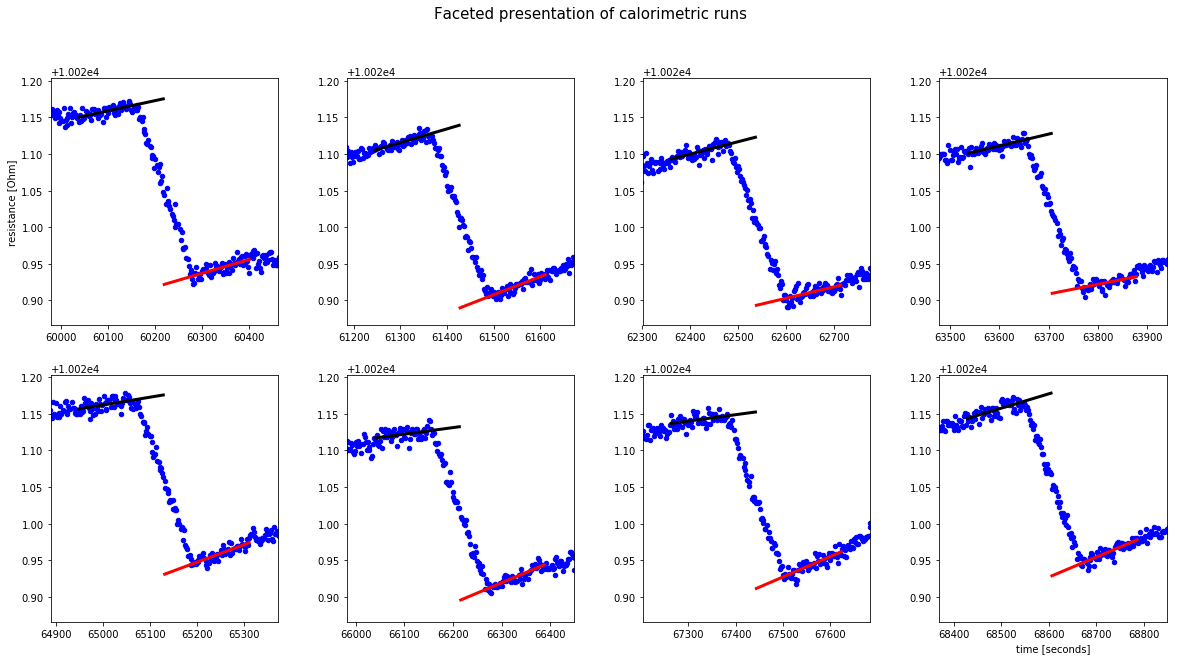

In [114]:
%matplotlib inline
results_fig = pyplt.figure(figsize=(20,10))
results_grid = matplotlib.gridspec.GridSpec(2, 4, hspace=0.2, wspace=0.3)
results_fig.suptitle("Faceted presentation of calorimetric runs", fontsize=15)

ax1 = results_fig.add_subplot(results_grid[0,0])
ax1.scatter(time,resistance, marker ='o', s=20, c='blue')
ax1.plot(time[x1[0]:xmid[0]], line_pre[0], color='black', linewidth=3.0)
ax1.plot(time[xmid[0]:x4[0]], line_post[0], color='red', linewidth=3.0)
ax1.set_xlim(xlim1[0],xlim2[0])
ax1.set_ylabel("resistance [Ohm]")
#ax1.text(0.6,0.79,"ID: "+time[x2[0]].astype('str')+", DeltaR_R: "+delta_R_over_R[0].astype('str')[:6]+"e-5", fontsize=12, wrap=True,
#            horizontalalignment='left')

ax2 = results_fig.add_subplot(results_grid[0,1])
ax2.scatter(time,resistance, marker ='o', s=20, c='blue')
ax2.plot(time[x1[1]:xmid[1]], line_pre[1], color='black', linewidth=3.0)
ax2.plot(time[xmid[1]:x4[1]], line_post[1], color='red', linewidth=3.0)
ax2.set_xlim(xlim1[1],xlim2[1])

ax3 = results_fig.add_subplot(results_grid[0,2])
ax3.scatter(time,resistance, marker ='o', s=20, c='blue')
ax3.plot(time[x1[2]:xmid[2]], line_pre[2], color='black', linewidth=3.0)
ax3.plot(time[xmid[2]:x4[2]], line_post[2], color='red', linewidth=3.0)
ax3.set_xlim(xlim1[2],xlim2[2])

ax4 = results_fig.add_subplot(results_grid[0,3])
ax4.scatter(time,resistance, marker ='o', s=20, c='blue')
ax4.plot(time[x1[3]:xmid[3]], line_pre[3], color='black', linewidth=3.0)
ax4.plot(time[xmid[3]:x4[3]], line_post[3], color='red', linewidth=3.0)
ax4.set_xlim(xlim1[3],xlim2[3])

ax5 = results_fig.add_subplot(results_grid[1,0])
ax5.scatter(time,resistance, marker ='o', s=20, c='blue')
ax5.plot(time[x1[4]:xmid[4]], line_pre[4], color='black', linewidth=3.0)
ax5.plot(time[xmid[4]:x4[4]], line_post[4], color='red', linewidth=3.0)
ax5.set_xlim(xlim1[4],xlim2[4])

ax6 = results_fig.add_subplot(results_grid[1,1])
ax6.scatter(time,resistance, marker ='o', s=20, c='blue')
ax6.plot(time[x1[5]:xmid[5]], line_pre[5], color='black', linewidth=3.0)
ax6.plot(time[xmid[5]:x4[5]], line_post[5], color='red', linewidth=3.0)
ax6.set_xlim(xlim1[5],xlim2[5])

ax7 = results_fig.add_subplot(results_grid[1,2])
ax7.scatter(time,resistance, marker ='o', s=20, c='blue')
ax7.plot(time[x1[6]:xmid[6]], line_pre[6], color='black', linewidth=3.0)
ax7.plot(time[xmid[6]:x4[6]], line_post[6], color='red', linewidth=3.0)
ax7.set_xlim(xlim1[6],xlim2[6])

ax8 = results_fig.add_subplot(results_grid[1,3])
ax8.scatter(time,resistance, marker ='o', s=20, c='blue')
ax8.plot(time[x1[7]:xmid[7]], line_pre[7], color='black', linewidth=3.0)
ax8.plot(time[xmid[7]:x4[7]], line_post[7], color='red', linewidth=3.0)
ax8.set_xlim(xlim1[7],xlim2[7])
ax8.set_xlabel("time [seconds]")

pyplt.savefig(dir_img+"/"+"faceted_plots"+".png")